In [1]:
import os
import cv2
import numpy as np
from skimage.transform import resize
from tqdm.notebook import tqdm

In [2]:
REBUILD_DATA = False

In [5]:
class LightingControlType:
    IMG_SIZE = 50

    CONTINUOUS = "profiles_jxl/CONTINUOUS_pic"
    CONTINUOUS_OFF = "profiles_jxl/CONTINUOUS_OFF_pic"
    STEPPED = "profiles_jxl/STEPPED_pic"

    LABELS = {CONTINUOUS: 0, CONTINUOUS_OFF: 1, STEPPED: 2}

    training_data = []
    count_cont = 0
    count_contoff = 0
    count_step = 0

    def make_training_data(self):
        for label in tqdm(self.LABELS):
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    onehot = np.eye(3)[
                        self.LABELS[label]
                    ]  # turn the scalor labels to one hot vector
                    self.training_data.append([np.array(img), onehot])

                    if label == self.CONTINUOUS:
                        self.count_cont += 1
                    if label == self.CONTINUOUS_OFF:
                        self.count_contoff += 1
                    if label == self.STEPPED:
                        self.count_step += 1
                except Exception as e:
                    print(str(e))
                    pass
        np.random.shuffle(self.training_data)  # no need to reasign, this is in place
        np.save("training_data.npy", self.training_data)
        print(f"Continuous: {self.count_cont}")
        print(f"Continuous_off: {self.count_contoff}")
        print(f"Stepped: {self.count_step}")

In [6]:
if REBUILD_DATA:
    lct = LightingControlType()
    lct.make_training_data()



Continuous: 8736
Continuous_off: 8736
Stepped: 8736


In [8]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

26208


In [9]:
training_data[0][0].shape

(50, 50)

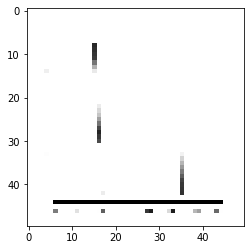

[0. 0. 1.]


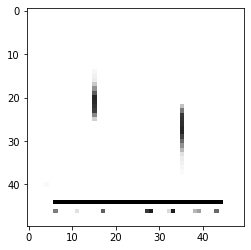

[0. 1. 0.]


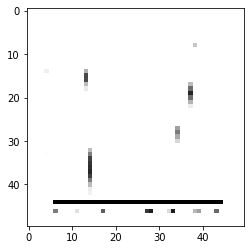

[0. 1. 0.]


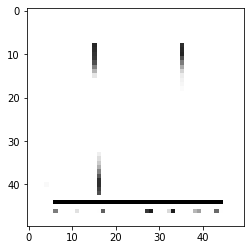

[0. 1. 0.]


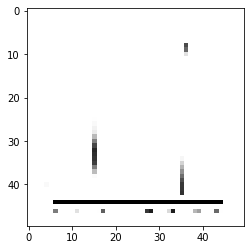

[0. 1. 0.]


In [11]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(training_data[i][0], cmap="gray")
    plt.show()
    print(training_data[i][1])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        # use the following lines to check the number for input to fc layer
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


net = Net()

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [14]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0  # scale the image to 0-1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

2620


In [15]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

23588
2620


In [23]:
a = 0
b = 0
c = 0
for i in test_y:
    a += i[0]
    b += i[1]
    c += i[2]

print(a, b, c)

tensor(879.) tensor(857.) tensor(884.)


In [16]:
BATCH_SIZE = 100  # change to smaller if got memory error

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i : i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i : i + BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(loss)


tensor(0.1037, grad_fn=<MseLossBackward>)



tensor(0.0152, grad_fn=<MseLossBackward>)



tensor(0.0057, grad_fn=<MseLossBackward>)



tensor(0.0039, grad_fn=<MseLossBackward>)



tensor(0.0023, grad_fn=<MseLossBackward>)



In [17]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print(f"Accuracy: {round(correct/total,3)}")


Accuracy: 0.969
